<a href="https://colab.research.google.com/github/sultanbst123/AnalyticsVidya_Bigmart/blob/main/cifar10_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# (VIT)Vision Transformers and (EANet) External Attention

In [ ]:
pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 4.4 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt

import tensorflow as tf 
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import *
from tensorflow.keras.activations import *
from tensorflow.keras.losses import *
from tensorflow.keras.metrics import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.utils import plot_model, to_categorical

import tensorflow_addons as tfa

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# setting seed

def set_seed(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed()

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

#x_train = x_train.astype("float32") / 255.0
#x_test = x_test.astype("float32") / 255.0
y_train = to_categorical(y_train)
#y_test = to_categorical(y_test)

In [ ]:
AUTO = tf.data.AUTOTUNE
batch_size = 64

num_classes = 10
input_shape = (32, 32, 3)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 10)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 10)


In [ ]:

# ambil secara manual 5000 data train terakhir ke data validation

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(1000).batch(batch_size).prefetch(AUTO)

val_ds = tf.data.Dataset.from_tensor_slices((x_train[45000:], y_train[45000:]))
val_ds = val_ds.batch(batch_size).prefetch(AUTO)

In [ ]:
train_ds, val_ds

(<PrefetchDataset shapes: ((None, 32, 32, 3), (None, 10)), types: (tf.uint8, tf.float32)>,
 <PrefetchDataset shapes: ((None, 32, 32, 3), (None, 10)), types: (tf.uint8, tf.float32)>)

In [ ]:
# Vit hyper parameters
patch_size = 8 # Size of the patches to be extracted from the input images.
image_size = 74 # resize image
num_patches = (image_size // patch_size) ** 2  # Number of patch
embedding_dim = 64 # Number of hidden units

dim_coefficient = 4
attention_dropout = 0.0
projection_dropout = 0.0
num_heads = 8 # attention heads
num_transformer_blocks = 8 # Number of repetitions of the transformer layer
mlp_dim = 256 # mlp units 

print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")

Patch size: 8 X 8 = 64 
Patches per image: 81


In [ ]:

# make a image augmentation 

data_augmentation = Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.1),
        layers.RandomContrast(factor=0.1),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [ ]:
#Menerapkan ekstraksi tambalan(PatchExtract) dan lapisan penyandian(PatchEmbedding) 

class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super(PatchExtract, self).__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=(1, self.patch_size, self.patch_size, 1),
            strides=(1, self.patch_size, self.patch_size, 1),
            rates=(1, 1, 1, 1),
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super(PatchEmbedding, self).__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(pos)

Image size: 97 X 97
Patch size: 8 X 8
Patches per image: 144
Elements per patch: 192


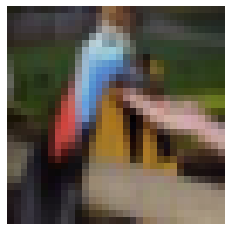

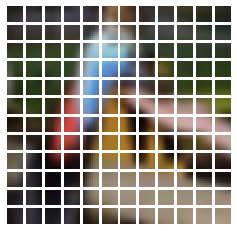

In [ ]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = PatchExtract(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
#Terapkan blok perhatian eksternal(external_attention) 

def external_attention(x, dim, num_heads, dim_coefficient=4, attention_dropout=0, projection_dropout=0):
    _, num_patch, channel = x.shape
    assert dim % num_heads == 0 # must return True
    num_heads = num_heads * dim_coefficient

    x = layers.Dense(dim * dim_coefficient)(x)
    # create tensor [batch_size, num_patches, num_heads, dim*dim_coefficient//num_heads]
    x = tf.reshape(
        x, shape=(-1, num_patch, num_heads, dim * dim_coefficient // num_heads)
    )
    x = tf.transpose(x, perm=[0, 2, 1, 3])
    # a linear layer M_k
    attn = layers.Dense(dim // dim_coefficient)(x)
    # normalize attention map
    attn = layers.Softmax(axis=2)(attn)
    # dobule-normalization
    attn = attn / (1e-9 + tf.reduce_sum(attn, axis=-1, keepdims=True))
    attn = layers.Dropout(attention_dropout)(attn)
    # a linear layer M_v
    x = layers.Dense(dim * dim_coefficient // num_heads)(attn)
    x = tf.transpose(x, perm=[0, 2, 1, 3])
    x = tf.reshape(x, [-1, num_patch, dim * dim_coefficient])
    # a linear layer to project original dim
    x = layers.Dense(dim)(x)
    x = layers.Dropout(projection_dropout)(x)
    return x

In [ ]:

# mlp 1 layers dengan gelu(Gaussian Error Linear Unit) 

def mlp(x, embedding_dim, mlp_dim, drop_rate=0.0):
    x = layers.Dense(mlp_dim, activation=tfa.activations.gelu)(x)
    x = layers.Dropout(drop_rate)(x)
    x = layers.Dense(embedding_dim)(x)
    x = layers.Dropout(drop_rate)(x)
    return x

In [ ]:
def transformer_encoder(
    x,
    embedding_dim,
    mlp_dim,
    num_heads,
    dim_coefficient,
    attention_dropout,
    projection_dropout,
    attention_type="external_attention",
):
    residual_1 = x
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    if attention_type == "external_attention":
        x = external_attention(
            x,
            embedding_dim,
            num_heads,
            dim_coefficient,
            attention_dropout,
            projection_dropout,
        )
    elif attention_type == "self_attention":
        x = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embedding_dim, dropout=attention_dropout
        )(x, x)
    x = layers.add([x, residual_1])
    residual_2 = x
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = mlp(x, embedding_dim, mlp_dim)
    x = layers.add([x, residual_2])
    return x

In [ ]:
def get_model(attention_type="external_attention"):
    inputs = layers.Input(shape=input_shape)
    # Image augment
    x = data_augmentation(inputs)
    # Extract patches.
    x = PatchExtract(patch_size)(x)
    # Create patch embedding.
    x = PatchEmbedding(num_patches, embedding_dim)(x)
    # Create Transformer block.
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(
            x,
            embedding_dim,
            mlp_dim,
            num_heads,
            dim_coefficient,
            attention_dropout,
            projection_dropout,
            attention_type,
       ) 

    x = layers.GlobalAvgPool1D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
vit = get_model("self_attention")

In [ ]:
vit.count_params() # total paramter dari vision transformer

1346321

In [ ]:
eanet = get_model()

In [ ]:
eanet.count_params() #total parameter external attention transformer

551889

In [ ]:
# Hyperparamters for fit 

EPOCHS = 10
INIT_LR = 5e-4
MAX_LR = 5e-2
Wd = 1e-5


#define Callbacks
steps_per_epoch =  45000 // 256 # validation split 0.1

clr = tfa.optimizers.Triangular2CyclicalLearningRate(
    initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    step_size= 2 * steps_per_epoch
)

cb_checkpt = ModelCheckpoint("best.hdf5", monitor = 'val_loss', verbose = 0,
                                 save_best_only = True,
                                 save_weights_only = True,
                                 mode = 'min')

es = EarlyStopping(monitor="val_loss", patience=10, verbose=1, mode="min", restore_best_weights=True)


#define metrics
METRICS = [tf.keras.metrics.CategoricalAccuracy(name = "accuracy"),
           tf.keras.metrics.TopKCategoricalAccuracy(5, name= "top-5-accuracy")]


#define optimizers 
ADAM = Adam(learning_rate=clr)

SGD = tf.keras.optimizers.SGD(learning_rate=clr, momentum=0.9) 
ADAMBELIEF = tfa.optimizers.AdaBelief(learning_rate = clr, weight_decay = Wd)#recified == True default,  warmup 0.1
ADAMW = tfa.optimizers.AdamW(learning_rate = clr, weight_decay = Wd)

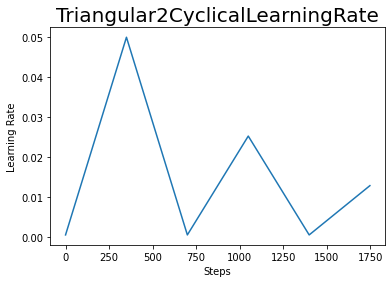

In [ ]:
step = np.arange(0, EPOCHS * steps_per_epoch)
lr = clr(step)
plt.plot(step, lr)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.title("Triangular2CyclicalLearningRate", size=20) 
plt.show()

In [ ]:
# fit eanet
eanet = get_model()
eanet.compile(optimizer = ADAMBELIEF,
            loss = "CategoricalCrossentropy", 
            metrics = METRICS)

In [ ]:
history = eanet.fit(train_ds, validation_data=val_ds,batch_size=256, 
                  epochs = EPOCHS,callbacks = [cb_checkpt])

Epoch 1/10
782/782 [==============================] - 253s 255ms/step - loss: 1.8641 - accuracy: 0.3221 - top-5-accuracy: 0.8326 - val_loss: 1.4018 - val_accuracy: 0.4792 - val_top-5-accuracy: 0.9326
Epoch 2/10
782/782 [==============================] - 197s 252ms/step - loss: 1.5019 - accuracy: 0.4548 - top-5-accuracy: 0.9120 - val_loss: 1.2427 - val_accuracy: 0.5484 - val_top-5-accuracy: 0.9488
Epoch 3/10
782/782 [==============================] - 197s 252ms/step - loss: 1.3079 - accuracy: 0.5272 - top-5-accuracy: 0.9399 - val_loss: 1.2001 - val_accuracy: 0.5672 - val_top-5-accuracy: 0.9546
Epoch 4/10
782/782 [==============================] - 197s 251ms/step - loss: 1.1773 - accuracy: 0.5765 - top-5-accuracy: 0.9524 - val_loss: 0.9842 - val_accuracy: 0.6432 - val_top-5-accuracy: 0.9746
Epoch 5/10
782/782 [==============================] - 197s 251ms/step - loss: 1.0608 - accuracy: 0.6224 - top-5-accuracy: 0.9627 - val_loss: 0.8904 - val_accuracy: 0.6790 - val_top-5-accuracy: 0.9778


In [ ]:
_, accuracy, top_5_accuracy = eanet.evaluate(val_ds) 
print(f"Val accuracy: {round(accuracy * 100, 2)}%")
print(f"Val top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

79/79 [==============================] - 7s 84ms/step - loss: 0.6863 - accuracy: 0.7596 - top-5-accuracy: 0.9870
Val accuracy: 75.96%
Val top 5 accuracy: 98.7%


In [ ]:
## untuk data test(unseen)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
y_predict = np.argmax(eanet.predict(x_test), axis=1)

In [ ]:
y_actual = y_test.copy()

In [ ]:
print(f"Accuracy score: {accuracy_score(y_actual,y_predict)}")

Accuracy score: 0.6965


In [ ]:
confusion_matrix(y_actual,y_predict)

array([[725,  31,  25,   3,  10,  14,  10,  29, 117,  36],
       [ 38, 774,   8,  10,   2,   5,   4,   9,  31, 119],
       [ 67,  12, 533,  39, 125,  41, 100,  59,  16,   8],
       [ 26,  10,  52, 390,  53, 275, 115,  44,  19,  16],
       [ 25,   3,  54,  31, 640,  40,  98,  95,  10,   4],
       [  7,   4,  34,  95,  35, 701,  37,  65,   9,  13],
       [  6,   3,  31,  32,  36,  20, 845,   9,  10,   8],
       [ 21,   3,  26,  23,  47,  74,  13, 765,   6,  22],
       [ 55,  29,  11,  14,   6,   4,   9,   6, 841,  25],
       [ 39,  86,   8,   9,   4,   7,  20,  27,  49, 751]])

In [ ]:
classification_report(y_actual, y_predict)

'              precision    recall  f1-score   support\n\n           0       0.72      0.72      0.72      1000\n           1       0.81      0.77      0.79      1000\n           2       0.68      0.53      0.60      1000\n           3       0.60      0.39      0.47      1000\n           4       0.67      0.64      0.65      1000\n           5       0.59      0.70      0.64      1000\n           6       0.68      0.84      0.75      1000\n           7       0.69      0.77      0.73      1000\n           8       0.76      0.84      0.80      1000\n           9       0.75      0.75      0.75      1000\n\n    accuracy                           0.70     10000\n   macro avg       0.70      0.70      0.69     10000\nweighted avg       0.70      0.70      0.69     10000\n'